In [1]:
# This script fetches weather data from a given URL, processes it to identify the header row,
# and loads it into a pandas DataFrame for further analysis and visualization.
# Author: Dima Kozlovskyy


# Import necessary libraries.
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Getting Data

In [2]:
# Define the URL for the weather data CSV file.
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"

In [3]:
# Our data has some metadata at the top, so we need to find where the actual data starts.
# Getting ready the data to load into DataFrame by identifying the header row number.

lines = requests.get(url).text.splitlines()

start_header = 0
i = 0

# Loop through lines to find the header row (the first line with more than one comma).
for line in lines:
    commas = re.findall(r',', line)
    if len(commas) > 1:
        start_header = i
        break
    i += 1

print(f"Header starts at line: {start_header}") # Will give the output of 23.

Header starts at line: 23


In [4]:
# Now we can use skiprows with 23.
df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=start_header)

df.columns

/tmp/ipykernel_5819/1956283021.py:2: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=start_header)


Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt'],
      dtype='object')

/tmp/ipykernel_5819/2880292262.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


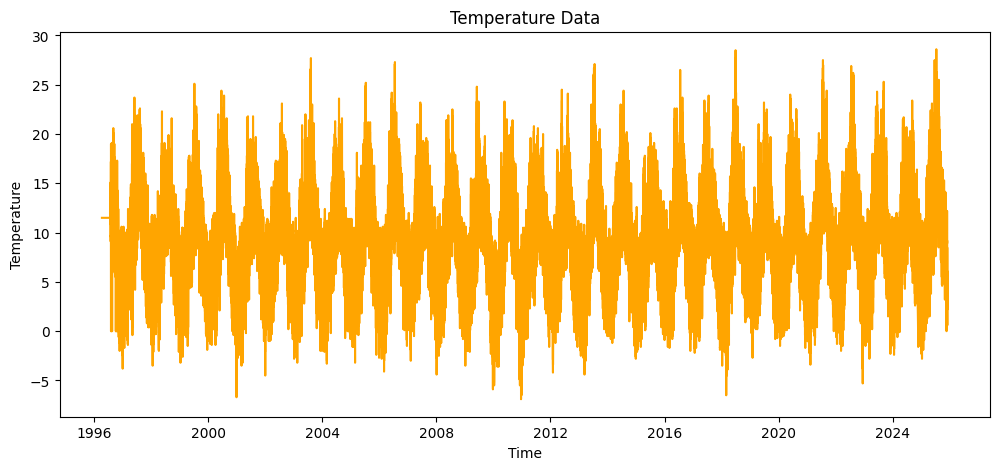

In [5]:

# Plotting temperature data.

temperature_data = df['temp']
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12,5)) # Adjust the figure size as needed.
plt.plot(df['date'], df['temp'], color='orange')
plt.title('Temperature Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

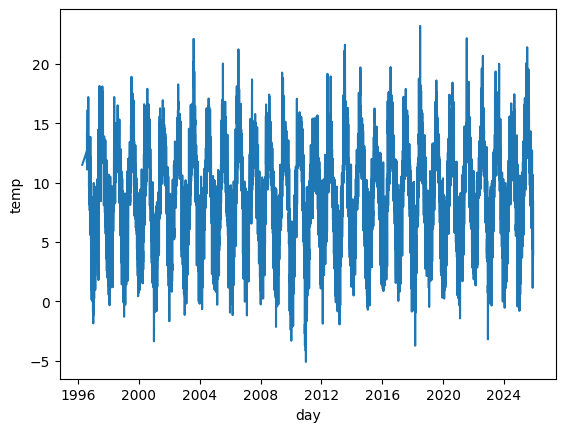

In [6]:
# Plotting the mean temperature each day.

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df['day'] = df['date'].dt.date
daily_mean = df.groupby('day')['temp'].mean().reset_index()

sns.lineplot(data=daily_mean, x='day', y='temp')
plt.show()


#sns.lineplot(df[fields], x='date', y='temp')


In [7]:
df['month'] = df['date'].dt.month
monthly_mean = df.groupby('month')['temp'].mean().reset_index()

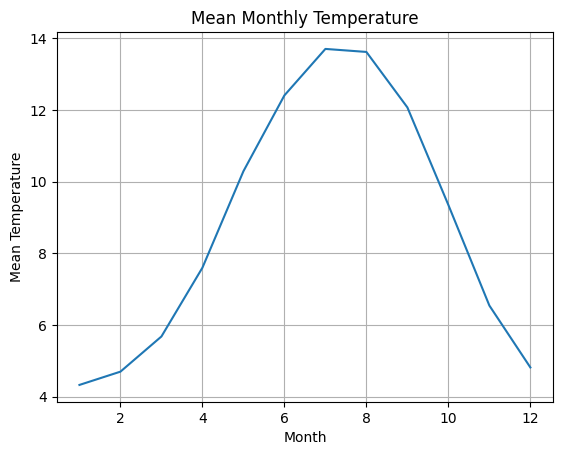

In [8]:
# Plotting the mean temperature each month.
sns.lineplot(data=monthly_mean, x='month', y='temp')
plt.title('Mean Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.grid(True)
plt.show()

In [9]:
# In a Windspeed Series we have some missing values, we can try to get them in a list to understand which method to use to miss them..
bad_values = []

for i in df['wdsp']:
    try:
        float(i)  
    except:
        bad_values.append(i) 

# Now we know that we have only empty strings as bad values.
print(bad_values)
print(len(bad_values)) # In amount of 50

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
50


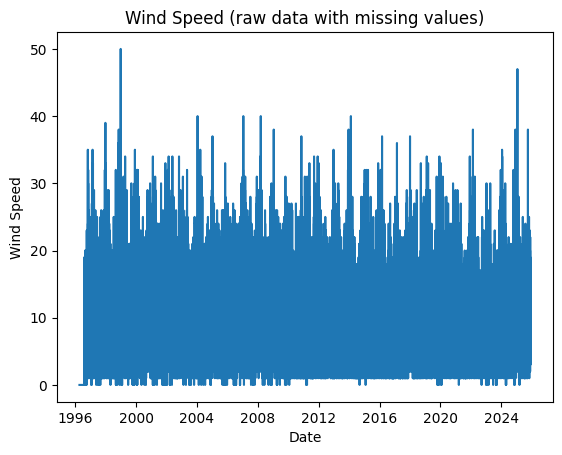

In [10]:

# Converting 'wdsp' column to numeric, coercing errors to NaN.
df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce')


# Plotting Wind Speed data with missing values.
sns.lineplot(data=df, x='date', y='wdsp')
plt.title("Wind Speed (raw data with missing values)")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

The rolling windspeed (say over 24 hours)

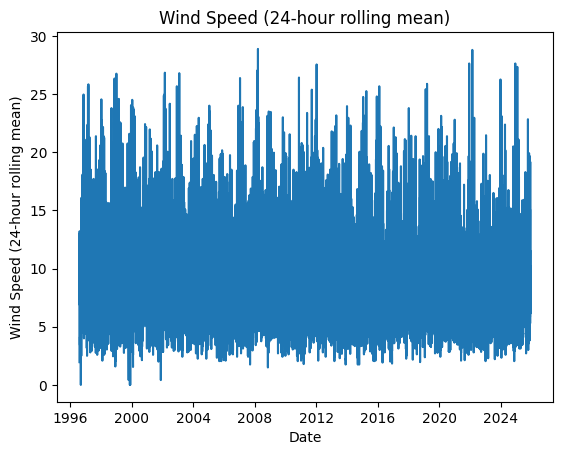

In [11]:
df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce')

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html#pandas-dataframe-rolling
df['wdsp_roll24'] = df['wdsp'].rolling(window=24).mean()

# Plot.
sns.lineplot(data=df, x='date', y='wdsp_roll24')
plt.title("Wind Speed (24-hour rolling mean)")
plt.xlabel("Date")
plt.ylabel("Wind Speed (24-hour rolling mean)")
plt.show()

The max windspeed for each day

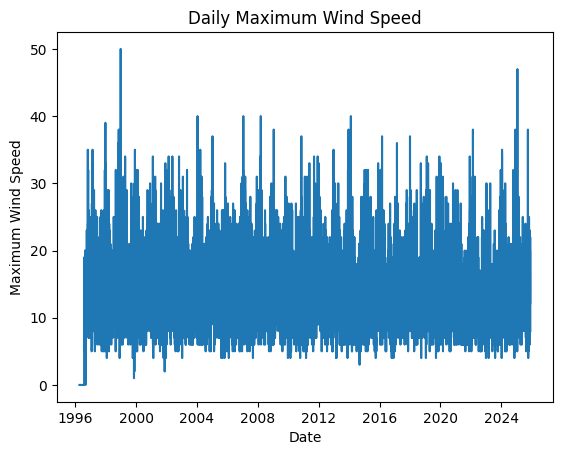

In [12]:
df['day'] = df['date'].dt.date

daily_max = df.groupby('day')['wdsp'].max().reset_index()

# Plotting daily maximum wind speed.
sns.lineplot(data=daily_max, x='day', y='wdsp')
plt.title("Daily Maximum Wind Speed")
plt.xlabel("Date")
plt.ylabel("Maximum Wind Speed")
plt.show()

The monthly mean of the daily max windspeeds

In [16]:
df.columns

Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt', 'day', 'month', 'wdsp_roll24'],
      dtype='object')

In [17]:
daily_max = df.groupby(df['date'].dt.date)['wdsp'].max().reset_index()

daily_max['date'] = pd.to_datetime(daily_max['date'], errors='coerce')

daily_max['month'] = daily_max['date'].dt.to_period('M').dt.to_timestamp()

monthly_mean_max = daily_max.groupby('month')['wdsp'].mean().reset_index()

#monthly_mean_max

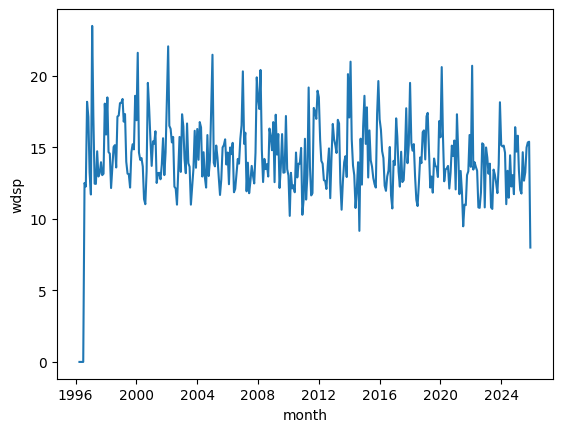

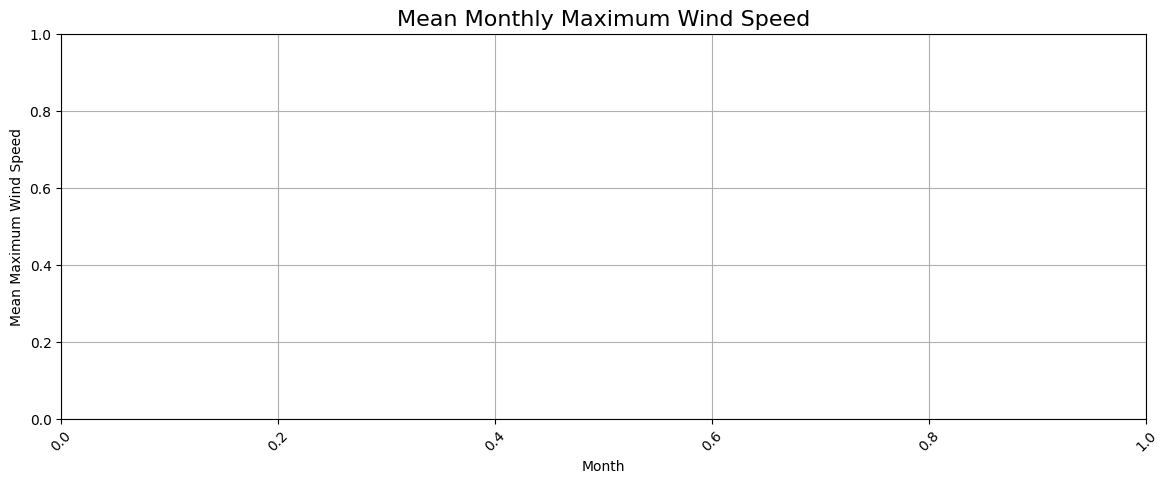

In [18]:
# Plot. 
sns.lineplot(data=monthly_mean_max, x='month', y='wdsp')
plt.figure(figsize=(14,5))
plt.title("Mean Monthly Maximum Wind Speed", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Mean Maximum Wind Speed")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()